In [1]:
import os
from glob import glob
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.model_selection import KFold
plt.style.use('figure.mplstyle')

from function.data2p import get_data_bis
import function.tuning_function as tf
import function.utils as ut
from decoder.manifold import SpatialDecoder
from decoder.metrics import get_error

## Load data

In [2]:
folder = r'D:\LW_Alldata\SI_Transient'
alldata = {'Enriched': glob(os.path.join(folder,'Enriched*.hdf5')),
           'Dissimilar': glob(os.path.join(folder,'Distinct*.hdf5')),
           'Similar': glob(os.path.join(folder,'Similar*.hdf5'))}

datapath = alldata['Enriched'][2]
day = 1  # Recording days, None for all days
min_rate = 0/60  # Minimum transient rate for active cells
ybin = 80  # Number of spatial bins
ysigma = 2  # Size of the Gaussian filter (in number of spatial bin) for smoothing the tuning curves

In [3]:
data, cells, days, ctx, _ = get_data_bis(datapath, day=day, min_rate=min_rate, verbose=True)

with h5py.File(datapath, 'r') as f:
    yrange = f['params/yrange'][()]  # Dataset dependent
    
print('Recording days:', days)
print('Context fam/nov:', ctx)

------------------------------------
Total cells: 91
Active cells: 90
Proportion of active cells 98.90 %
Active in both 97.80 %
Active exclusively in Fam 1.10 %
Active exclusively in Nov 0.00 %
------------------------------------
Recording days: [1 1 1 1]
Context fam/nov: [0 1 0 1]


## Prepare data (spatial tuning)

In [4]:
tuning = tf.compute_tuning(data, yrange=yrange, ybin=ybin, ysigma=ysigma,
                           spike=False, transient=True)

In [5]:
def collect_data(tuning, ctx=np.array([0,1,0,1]), ybin=80):
    
    y_edges = np.linspace(0,4,ybin+1)  # Unify position data to (0,4)
    y_centers = (y_edges[:-1] + y_edges[1:])/2
    Fdata, ydata  = [], []
    for c in range(len(set(ctx))):
        F = np.concatenate([tuning[k] for k in np.where(ctx==c)[0]], axis=2)  # (ncell, ybin, ntrial)
        Fdata.append(np.transpose(F, (2,1,0)))  # (ntrial, ybin, ncell)
        ydata.append(np.tile(y_centers, (F.shape[2],1)))  # (ntrial, ybin)
        
    return Fdata, ydata

Fdata, ydata = collect_data(tuning, ctx=ctx, ybin=ybin)

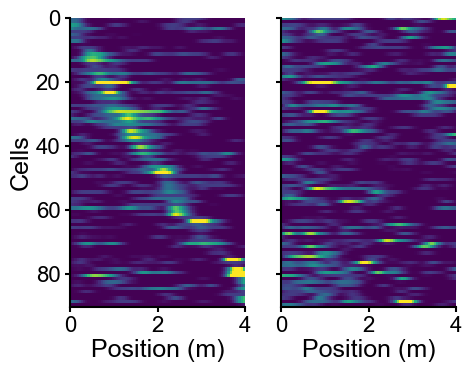

In [6]:
def display_tuning(Fdata, sort=0):
    
    tuning_mean = [F.mean(axis=0).T for F in Fdata]
    ncell = tuning_mean[0].shape[0]
    order = ut.sort_tuning(tuning_mean[sort])[1]
    vmax = np.percentile(np.hstack([M.ravel() for M in tuning_mean]), 99.5)
    
    fig, axs = plt.subplots(1,len(Fdata),figsize=(5,4),sharey=True)
    for c, M in enumerate(tuning_mean):
        axs[c].imshow(M[order], interpolation='none', vmin=0, vmax=vmax, extent=[0,4,ncell,0])
        axs[c].set_aspect('auto')
        axs[c].set_xlabel('Position (m)')
    axs[0].set_ylabel('Cells')
    fig.tight_layout()
    # fig.savefig('Test.svg')
    
display_tuning(Fdata, sort=0)

## Useful functions

In [7]:
def prepare_data(Fs, ys, trial=None, average=False):
    '''
    Parameters
    ----------
    Fs : numpy array (ntrial, ybin, ncell)
        Spatial tuning of a given mouse with all trials stacked along axis=0
    ys : numpy array (ntrial, ybin)
        Position vector of each trial
    trial : numpy 1d array
        Indices of selected trials
    average : bool
        Whether to average over trials

    Returns
    -------
    X : array (n_samples, ncell)
    y : array (n_samples,) 
        where n_samples = ybin if trial-averaged, otherwise n_samples = ntrial*ybin
    '''
    if trial is None:  # Take all trials
        trial = np.arange(Fs.shape[0])
    elif isinstance(trial, int):
        trial = [trial]   
    if average:
        X = np.mean(Fs[trial,:,:], axis=0)  # (ybin, ncell)
        y = np.mean(ys[trial,:], axis=0)  # (ybin,)
    else:
        X = np.vstack([Fs[r,:,:] for r in trial])
        y = np.hstack([ys[r,:] for r in trial])
    ## Discard points where all cells are silent
    silent = (X.sum(axis=1) == 0)
    if np.any(silent):
        X = X[~silent,:]
        y = y[~silent]
        
    return X, y

def decode_position_cv(Fs, ys, nfold=10, shuffle=0, y2cm=100, **kwargs):
    
    error = []
    if shuffle:
        cv = KFold(n_splits=nfold, shuffle=True, random_state=shuffle)
    else:
        cv = KFold(n_splits=nfold, shuffle=False)
    
    for train_set, test_set in cv.split(np.zeros((Fs.shape[0],1))): 
    
        X_train, y_train = prepare_data(Fs, ys, trial=train_set, average=True)
        X_test, y_test = prepare_data(Fs, ys, trial=test_set, average=False)
        
        spd = SpatialDecoder(**kwargs)
        spd.fit(X_train, y_train)
        y_pred = spd.predict(X_test)
        ind = np.isfinite(y_pred)
        if not np.all(ind):
            print('Warning: neglect %d NaN in test data (%.4g%% samples)' % (np.sum(~ind), 100*np.mean(~ind)))
        error.append(y2cm*get_error(y_test[ind], y_pred[ind], kind='median'))
    
    return np.array(error)

## Decode position from reduced neural space

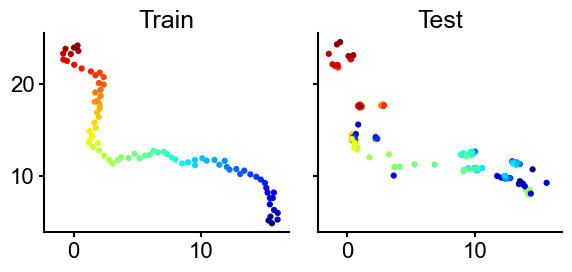

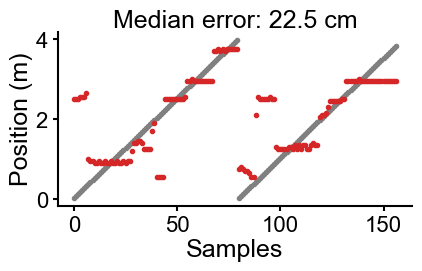

In [9]:
def decode_position_test(Fs, ys, test_set=[0], **kwargs):
    
    y_edges = np.linspace(*kwargs['yrange'], kwargs['ybin']+1)
    y_centers = (y_edges[:-1] + y_edges[1:])/2
    ntrial, ybin, ncell = Fs.shape  # Novel context
    train_set = np.setdiff1d(np.arange(ntrial), test_set)
    
    X_train, y_train = prepare_data(Fs, ys, trial=train_set, average=True)
    X_test, y_test = prepare_data(Fs, ys, trial=test_set, average=False)
    
    spd = SpatialDecoder(**kwargs)
    spd.fit(X_train, y_train)
    y_pred = spd.predict(X_test)
    ind = np.isfinite(y_pred)
    if not np.all(ind):
        print('Warning: neglect %d NaN in test data (%.4g%% samples)' % (np.sum(~ind), 100*np.mean(~ind)))
    error = get_error(y_test[ind], y_pred[ind], kind='median')
    
    fig, axs = plt.subplots(1,2,sharex=True,sharey=True,figsize=(6,3))
    axs[0].set_title('Train')
    axs[0].scatter(*spd.X_train_embed.T, c=y_train, cmap='jet', s=12, rasterized=True)
    axs[1].set_title('Test')
    axs[1].scatter(*spd.X_test_embed.T, c=y_test, cmap='jet', s=12, rasterized=True)
    fig.tight_layout()
    
    fig, ax = plt.subplots(figsize=(4.5,3))
    ax.plot(y_test, ls='none', marker='.', ms=6, c='gray')
    ax.plot(y_pred, ls='none', marker='.', ms=6, c='tab:red')
    ax.set_title('Median error: %.4g cm' % (error*100))
    ax.set(xlabel='Samples', ylabel='Position (m)')
    fig.tight_layout()

params = dict(method='knr', k=10, knr_metric='euclidean',  # 'knr'|'gpr'|'svr'|'pvcorr'|'bayesian'
              reduction='umap', dim=2,  # 'none'|'pca'|'umap'   
              yrange=(0,4), ybin=ybin,  # Used in pvcorr and bayesian
              n_neighbors=8, min_dist=0.6, metric='cosine', random_state=0)  # UMAP parameters 
              
decode_position_test(Fdata[0], ydata[0], test_set=[2,3], **params)

## Test decoding parameters

In [10]:
pars = [1,2,3,4,5,6]
errors = [[] for _ in range(len(pars))]

for d, par in enumerate(pars):
    print('Decoding position with parameter %g ...' % par)
    params = dict(method='knr', k=10, knr_metric='euclidean',  # 'knr'|'gpr'|'svr'|'pvcorr'|'bayesian'
                  reduction='umap', dim=par,  # 'none'|'pca'|'umap'   
                  yrange=(0,4), ybin=ybin,  # Used in pvcorr and bayesian
                  n_neighbors=8, min_dist=0.6, metric='cosine', random_state=0)  # UMAP parameters 
    
    errors[d] = decode_position_cv(Fdata[0], ydata[0], nfold=10, shuffle=2, y2cm=100, **params)

Decoding position with parameter 1 ...
Decoding position with parameter 2 ...
Decoding position with parameter 3 ...
Decoding position with parameter 4 ...
Decoding position with parameter 5 ...
Decoding position with parameter 6 ...


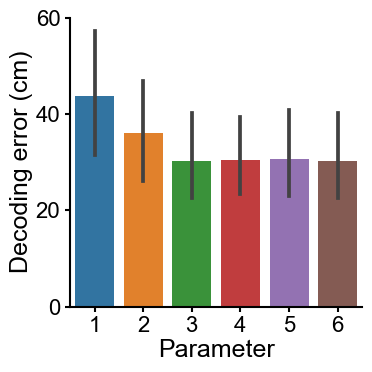

In [11]:
df = pd.DataFrame(np.column_stack(errors), columns=pars)  # (cv, n_pars)

fig, ax = plt.subplots(figsize=(4,4))
sns.barplot(df, ax=ax, errorbar=('ci',95))
ax.set(xlabel='Parameter', ylabel='Decoding error (cm)')
fig.tight_layout()

## Run for all datasets

In [12]:
datapaths = alldata['Enriched'] + alldata['Dissimilar'] + alldata['Similar']
day = 1  # Recording days, None for all days
min_rate = 0/60  # Minimum transient rate for active cells
ybin = 80  # Number of spatial bins
ysigma = 2  # Size of the Gaussian filter (in number of spatial bin) for smoothing the tuning curves
nfold = 10
shuffle = 2
dims = [1,2,3,4,5,6]
error_list = []

for p, datapath in enumerate(datapaths):
    
    print('Analyzing:', os.path.split(datapath)[1])
    
    data, cells, days, ctx, _ = get_data_bis(datapath, day=day, min_rate=min_rate)
    with h5py.File(datapath, 'r') as f:
        yrange = f['params/yrange'][()]  # Dataset dependent
        
    tuning = tf.compute_tuning(data, yrange=yrange, ybin=ybin, ysigma=ysigma, spike=False, transient=True) 
    Fdata, ydata = collect_data(tuning, ctx=ctx, ybin=ybin)
    
    errors = np.zeros((2,len(dims)))  # Fam and Nov
    for d, dim in enumerate(dims):
        
        print('Decoding position in %d dimension ...' % dim)
        params = dict(method='knr', k=10, knr_metric='euclidean',  # 'knr'|'gpr'|'svr'|'pvcorr'|'bayesian'
                      reduction='umap', dim=dim,  # 'none'|'pca'|'umap'   
                      yrange=(0,4), ybin=ybin,  # Used in pvcorr and bayesian
                      n_neighbors=8, min_dist=0.6, metric='cosine', random_state=0)  # UMAP parameters 
        
        for c in range(2):
            error = decode_position_cv(
                Fdata[c], ydata[c], nfold=nfold, shuffle=shuffle, y2cm=100, **params)
            errors[c,d] = np.mean(error)
    
    error_list.append(errors)
    
df = pd.DataFrame(np.vstack(error_list), columns=dims)  # (2*n_mice, ndim)
with pd.ExcelWriter('Decode position dimension.xlsx') as writer:
    df.to_excel(writer, sheet_name='Dim', index=False)

Analyzing: Enriched1_6044_invivo.hdf5
Decoding position in 1 dimension ...
Decoding position in 2 dimension ...
Decoding position in 3 dimension ...
Decoding position in 4 dimension ...
Decoding position in 5 dimension ...
Decoding position in 6 dimension ...
Analyzing: Enriched2_6045_invivo.hdf5
Decoding position in 1 dimension ...
Decoding position in 2 dimension ...
Decoding position in 3 dimension ...
Decoding position in 4 dimension ...
Decoding position in 5 dimension ...
Decoding position in 6 dimension ...
Analyzing: Enriched3_6160_invivo.hdf5
Decoding position in 1 dimension ...
Decoding position in 2 dimension ...
Decoding position in 3 dimension ...
Decoding position in 4 dimension ...
Decoding position in 5 dimension ...
Decoding position in 6 dimension ...
Analyzing: Enriched4_6161_invivo.hdf5
Decoding position in 1 dimension ...
Decoding position in 2 dimension ...
Decoding position in 3 dimension ...
Decoding position in 4 dimension ...
Decoding position in 5 dimension .

Decoding position in 6 dimension ...


In [13]:
# df_long = pd.DataFrame({'Error': np.hstack([err.ravel() for err in error_list]),
#                         'Dimension': np.tile(np.repeat(np.array(dims),2),len(datapaths))})
df_long = pd.DataFrame({'Error': np.hstack([err[0] for err in error_list]),  # Fam
                        'Dimension': np.tile(np.array(dims),len(datapaths))})
# print(df_long)

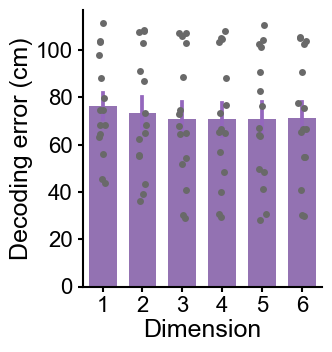

In [14]:
fig, ax = plt.subplots(figsize=(3.6,3.8))
sns.barplot(data=df_long, x='Dimension', y='Error', ax=ax, errorbar='se', width=0.7,
            color='tab:purple', errcolor='tab:purple')
sns.stripplot(data=df_long, x='Dimension', y='Error', ax=ax, color='dimgray')
ax.set(xlabel='Dimension', ylabel='Decoding error (cm)')
fig.tight_layout()
# fig.savefig('Decoding fam reduction.svg')

## Plot results

In [19]:
excelfile = r'C:\Users\Hung-Ling\Desktop\MC_Results\New Results\Decode position dimension.xlsx'
c = 0
# mice = [0,1,2,3,4,5,6]  # Distinct (Enriched and dissimilar)
mice = [0,2,3] + [4,5,6] + [7,8]  # Fam significnat ,11,12
# mice = [0,1,2,3] + [4,5,6] + [7,8,12,14] # Nov significant
dims = [1,2,3,4,5,6]

A = pd.read_excel(excelfile, sheet_name='Dim').to_numpy()  # (Mouse,Dim)
B = A[c::2][mice]
print(B)
df_long = pd.DataFrame({'Error': np.hstack([err for err in B]),  # Fam
                        'Dimension': np.tile(np.array(dims), B.shape[0])})

[[68.45  68.275 68.    65.1   67.05  66.75 ]
 [43.7   36.    30.25  30.5   30.775 30.25 ]
 [56.025 43.5   41.025 39.9   41.225 40.75 ]
 [74.625 64.825 65.15  66.475 63.75  66.55 ]
 [45.55  39.    28.875 29.625 28.25  29.825]
 [64.7   55.25  54.525 57.    48.5   54.775]
 [79.9   73.575 73.2   73.575 76.525 75.5  ]
 [63.175 55.5   51.825 48.6   49.55  54.975]]


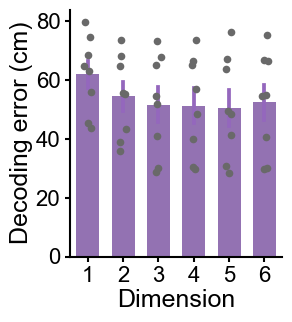

In [29]:
fig, ax = plt.subplots(figsize=(3.2,3.5))
sns.barplot(data=df_long, x='Dimension', y='Error', ax=ax, errorbar='se', width=0.65,
            color='tab:purple', errcolor='tab:purple')
sns.stripplot(data=df_long, x='Dimension', y='Error', ax=ax, color='dimgray', size=5.5)
ax.set(xlabel='Dimension', ylabel='Decoding error (cm)')
fig.tight_layout()
fig.savefig('Decoding reduction fam significant.svg')